In [320]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ast import literal_eval
import seaborn as sns
from CSV_clean import df_select_max_epoch
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
# from settings import TAU
import settings
import time
import importlib
importlib.reload(settings)
from settings import TAU

print('loaded TAU', TAU)

loaded TAU 7.5


In [7]:
def select_data_from_df(df, learning_rate, nodes, layers, option, max_epochs, normalization_methods=None, activation_functions=None):
    """"
    From the dataframe with all the data the data with given specifications is selected.
    It has also been made sure that only the data trained up to the max epoch has been selected. 
    """
    # select all these data
    if normalization_methods is None and activation_functions is None:
        df_selection = df[
                    (df['learning_rate'] == learning_rate) &
                    (df['nodes'].apply(lambda x: x == nodes)) &
                    (df['layers'] == layers) &
                    (df['option'] == option)
                    ]
    else:
        df_selection = df[
                    (df['learning_rate'] == learning_rate) &
                    (df['nodes'].apply(lambda x: x == nodes)) &
                    (df['layers'] == layers) &
                    (df['option'] == option) &
                    (df['normalization_method'].isin(normalization_methods)) &
                    (df['activation_function'].isin(activation_functions))
                    ]
    # select data with maximal epoch of training = max_epochs
    df_selection = df_select_max_epoch(df_selection, max_epochs)
    return df_selection

def df_select_max_epoch(df_selection, max_epochs):
    """From a df_selection tries to choose only the values with right amount of epochs (not more)
    
    Input
    ------
    df_selection:
      Dataframe containing all runs to go up to max_epochs (or higher) where norm, activ, lr, layers, nodes, option have already been selected
    max_epochs:
      Epoch limit that model was trained on
      
    Returns
    -------
    pandas.dataframe
      Returns the dataframe with the selected models (and the epochs going from 0 to max_epochs)
    """
    modelnames = df_selection["modelname"].unique()
    modelnames_selection = []
    for modelname in modelnames:
        count_modelname = df_selection["modelname"].value_counts()[modelname]
        if count_modelname == max_epochs + 1:
            modelnames_selection.append(modelname)
    df_selection_modelname = df_selection[(df_selection["modelname"].isin(modelnames_selection))]
    assert len(modelnames_selection) != 0, "No models found"
    return df_selection_modelname


In [50]:
# data prepare
def validation_data_compare_fast(normalization_method, activation_function, learning_rate, nodes, layers, max_epochs, option, average=1, df=None):
    """
    all epochs
    """
    # Load DataFrame
    # absolute_path = os.path.dirname(__file__)
    if df is None:
        absolute_path = os.path.abspath('')
        relative_path = f"FHN_NN_loss_and_model_{TAU}.csv"
        csv_name = os.path.join(absolute_path, relative_path)
        df = pd.read_csv(csv_name, converters={"nodes": literal_eval, "mean_std": literal_eval}) # literal eval returns [2,2] as list not as str

    # Select data based on specified parameters
    df_selection = select_data_from_df(df, learning_rate, nodes, layers, option, max_epochs, normalization_methods=normalization_method, activation_functions=activation_function)
    # Only select last epoch (validation at max_epochs)
    # df_selection = df_selection[(df_selection["epoch"] == max_epochs)].reset_index(drop=True)

    end_validation_data = [[None] * len(normalization_method) for _ in range(len(activation_function))]   # to avoid deep/shallow copy
    end_training_data = [[None] * len(normalization_method) for _ in range(len(activation_function))]   # to avoid deep/shallow copy
    std_dev_validation_functions = [[None] * len(normalization_method) for _ in range(len(activation_function))]
    std_dev_training_functions = [[None] * len(normalization_method) for _ in range(len(activation_function))]

    for i, norm_method in enumerate(normalization_method):
        for j, activ_func in enumerate(activation_function):
            df = df_selection.copy()
            filtered_df = df[
                            (df['normalization_method'] == norm_method) &
                            (df['activation_function'] == activ_func) &
                            (df['learning_rate'] == learning_rate) &
                            (df['nodes'].apply(lambda x: x == nodes)) &
                            (df['layers'] == layers) &
                            (df['epoch']).between(0,max_epochs) &
                            (df['option'] == option)
                            ]
            grouped = filtered_df.groupby('epoch')['validation'].agg(['mean', 'std'])
            mean = np.array(grouped['mean'].tolist())
            std = np.array(grouped['std'].tolist())
            end_validation_data[j][i] = mean
            std_dev_validation_functions[j][i] = std
            grouped = filtered_df.groupby('epoch')['loss'].agg(['mean', 'std'])
            mean = np.array(grouped['mean'].tolist())
            std = np.array(grouped['std'].tolist())
            end_training_data[j][i] = mean
            std_dev_training_functions[j][i] = std

    
    return end_validation_data, std_dev_validation_functions, end_training_data, std_dev_training_functions, df_selection



In [242]:
from scipy.stats import f_oneway, shapiro, levene, kruskal, mannwhitneyu

def shapiro_and_levenes_test(data_group, alpha=0.05):
        # Shapiro test
    for data in data_group:
        statistic, p_value = shapiro(data)
        if p_value < alpha:  # alpha standard is 0.05
            print(f"Data does NOT satisfy Shapiros test, p-value: {p_value}")
            anova_check = False
        else: 
            print(f"Data DOES satisfy Shapiros test, p-value: {p_value}")

    # Levene's test
    statistic, p_value = levene(*data_group)
    print(p_value, "levene")
    if p_value < alpha:
        print(f"Data does NOT satisfy Levene's test, p-value: {p_value}")
        anova_check = False
    else:
        print(f"Data DOES satisfy Levene's test, p-value: {p_value}")


In [252]:
print(TAU, 'will be used as TAU')
absolute_path = os.path.abspath('')
relative_path = f"FHN_NN_loss_and_model_{TAU}.csv"
csv_name = os.path.join(absolute_path, relative_path)
df_overall = pd.read_csv(csv_name, converters={"nodes": literal_eval, "mean_std": literal_eval}) # literal eval returns [2,2] as list not as str
print("Tau used:", TAU)

7.5 will be used as TAU
Tau used: 7.5


In [268]:
tau_7_5 = 7.5
print(tau_7_5, 'will be used as TAU')
absolute_path = os.path.abspath('')
relative_path = f"FHN_NN_loss_and_model_{tau_7_5}.csv"
csv_name = os.path.join(absolute_path, relative_path)
df_overall_tau7_5 = pd.read_csv(csv_name, converters={"nodes": literal_eval, "mean_std": literal_eval}) # literal eval returns [2,2] as list not as str
print("Tau used:", tau_7_5)

7.5 will be used as TAU
Tau used: 7.5


In [270]:
tau_100 = 100
print(tau_100, 'will be used as TAU')
absolute_path = os.path.abspath('')
relative_path = f"FHN_NN_loss_and_model_{tau_100}.csv"
csv_name = os.path.join(absolute_path, relative_path)
df_overall_tau100 = pd.read_csv(csv_name, converters={"nodes": literal_eval, "mean_std": literal_eval}) # literal eval returns [2,2] as list not as str
print("Tau used:", tau_100)

100 will be used as TAU
Tau used: 100


In [235]:
normalization_method = ["no-norm", "z-score", "min-max"]
activation_function = ["relu", "tanh", "sigmoid"]
learning_rate = 0.01
max_epochs = 499
nodes = [8,8]
layers = 2
average = 40
option = 'option_3'

df = df_overall.copy()

print(TAU, 'used tau')
end_val_data, std_dev_val, end_training_data, std_dev_training, df_selection = validation_data_compare_fast(normalization_method, activation_function, learning_rate, nodes, layers, max_epochs, option, average, df=df)
print(TAU, 'used tau')

100 used tau
100 used tau


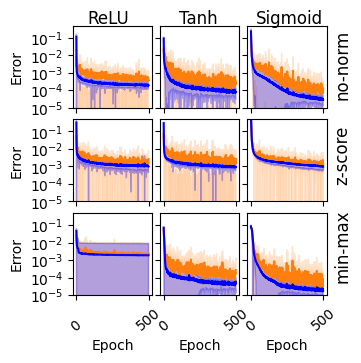

In [241]:
def plot_together_3by3_all_val(end_validation_data, std_dev_validation_functions, end_training_data, std_dev_training, normalization_method, activation_function, max_epochs):
    fig, axs = plt.subplots(3, 3, squeeze=False, figsize=(3.5,3.5))

    min_loss_tot = np.infty
    max_loss_tot = -np.infty

    for i in range(3):
        for j in range(3):
            # min_loss_tot = min(min(end_validation_data[j][i]-std_dev_loss_functions[j][i]), min_loss_tot)
            # max_loss_tot = max(max(end_validation_data[j][i]+std_dev_loss_functions[j][i]), max_loss_tot)
            min_loss_tot = min(min(end_training_data[j][i]), min_loss_tot)
            max_loss_tot = max(max(end_validation_data[j][i]), max_loss_tot)


    activation_function = ['ReLU', 'Tanh', 'Sigmoid']


    epochs = np.arange(0, max_epochs+1)
    for n, i in enumerate(normalization_method): # over normalization
        for m, j in enumerate(activation_function): # over activation
            axs[n, m].plot(epochs, end_validation_data[m][n], color='C1', label='validation')
            axs[n, m].fill_between(epochs, end_validation_data[m][n]-std_dev_validation_functions[m][n], end_validation_data[m][n]+std_dev_validation_functions[m][n], color='C1', alpha=0.2)
            axs[n, m].plot(epochs, end_training_data[m][n], color='blue', label='training')
            axs[n, m].fill_between(epochs, end_training_data[m][n]-std_dev_training[m][n], end_training_data[m][n]+std_dev_training[m][n], color='blue', alpha=0.3)
            # axs[n, m].errorbar(epochs, loss_functions[n][m], yerr=std_dev_loss_functions[n][m], color='orange', capsize=0.1, alpha=0.6)
            # axs[n, m].set_title(str(i) + ", " + str(j))
            axs[n, m].set_yscale('log')
            axs[n, m].set_ylim([min_loss_tot, max_loss_tot])
            # axs[n, m].set_xlabel("Epoch")
            # axs[n,m].set_ylabel("Validation Loss")
    # fig.suptitle(f"Validation Loss: Averaged over {average} in {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}")

    # axs[0,0].legend(frameon=False, bbox_to_anchor=[0.02, 1.1], loc='upper left', labelspacing=0.3)

    axs[2, 0].set_xlabel("Epoch")
    axs[2, 1].set_xlabel("Epoch")
    axs[2, 2].set_xlabel("Epoch")
    # axs[2,0].set_xticks([0, 500, 1000])
    # axs[2,1].set_xticks([0, 500, 1000])
    # axs[2,2].set_xticks([0, 500, 1000])
    axs[2,0].set_xticks([0, 500])
    axs[2,1].set_xticks([0, 500])
    axs[2,2].set_xticks([0, 500])

    axs[2,0].tick_params(axis='x', labelrotation=40)
    axs[2,1].tick_params(axis='x', labelrotation=40)
    axs[2,2].tick_params(axis='x', labelrotation=40)

    for i in [0,1,2]:
        ticks = axs[2,i].get_xticks()
        tick_labels = axs[2,i].get_xticklabels()
        # Move the first and last tick labels inwards
        tick_labels[0].set_position((ticks[0], -0.15))  # Adjust the vertical position of the first label
        # tick_labels[-1].set_position((ticks[-1], -0.1))  # Adjust the vertical position of the last label
        # Redraw the tick labels with the new positions
        axs[2,1].set_xticklabels(tick_labels)


    for n in [0,1]:
        for m in [0,1,2]:
            # axs[n,m].set_xticks([])
            axs[n,m].tick_params(labelbottom=False)    

    # axs[n,m].set_yticks([])


    axs[0,0].set_ylabel("Error")
    axs[1,0].set_ylabel("Error")
    axs[2,0].set_ylabel("Error")
    axs[0,0].set_yticks([0.1, 0.01, 0.001, 0.0001, 0.00001])
    axs[1,0].set_yticks([0.1, 0.01, 0.001, 0.0001, 0.00001])
    axs[2,0].set_yticks([0.1, 0.01, 0.001, 0.0001, 0.00001])

    for n in [0,1,2]:
        for m in [1,2]:
            # axs[n,m].set_yticks([])   
            axs[n,m].set_yticks([0.1, 0.01, 0.001, 0.0001, 0.00001])

            axs[n,m].tick_params(labelleft=False)    



    row_params = ['no-norm', 'z-score', 'min-max']

    # Add row annotations
    for i, param in enumerate(row_params):
        fig.text(0.97, 0.84 - i*0.26, param, va='center', ha='center', rotation='vertical', fontsize=12)

    col_params = ['ReLU', 'Tanh', 'Sigmoid']

    # Add column annotations
    for j, param in enumerate(col_params):
        fig.text(0.3 + j*0.26, 0.97, param, va='center', ha='center', fontsize=12)

    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 10)
    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 11)
    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 12)
    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 22)
    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 22)
    # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 22)



    plt.tight_layout()
    plt.subplots_adjust(hspace=0.14, wspace=0.1, top=0.95, bottom=0.18, left=0.2)


    mpl.rc("savefig", dpi=300)
    plt.savefig(r"C:\Users\jimmy\OneDrive\Documents\Universiteit\KULeuven\Masterproef\Thesis_Fig\Results\3x3vallossepoch_88_0.01_499_40_100.png")

    plt.show()

plot_together_3by3_all_val(end_validation_data=end_val_data, std_dev_validation_functions=std_dev_val, end_training_data=end_training_data, std_dev_training=std_dev_training, normalization_method=normalization_method, activation_function=activation_function, max_epochs=max_epochs)

C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\4053715787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:,'log_validation'] = np.log10(df_plot['validation'])


Data DOES satisfy Shapiros test, p-value: 0.6014820713516803
Data DOES satisfy Shapiros test, p-value: 0.07682396898926896
Data DOES satisfy Shapiros test, p-value: 0.47273558316966036
Data does NOT satisfy Shapiros test, p-value: 0.0003131274999331754
Data does NOT satisfy Shapiros test, p-value: 0.00019009421736483045
Data does NOT satisfy Shapiros test, p-value: 0.026370135382583686
Data does NOT satisfy Shapiros test, p-value: 0.0007357702200969052
Data DOES satisfy Shapiros test, p-value: 0.06552084233448932
Data DOES satisfy Shapiros test, p-value: 0.2002385888361024
2.9116560349182508e-05 levene
Data does NOT satisfy Levene's test, p-value: 2.9116560349182508e-05
Factor1 p-value: 0.0000
Factor2 p-value: 0.0000
Interaction p-value: 0.0000
Validation: 40 simulations, option_3.
 lr: 0.01, nodes: [8, 8], layers: 2, max epochs 499



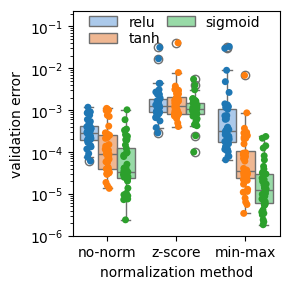

p-value, 9.990455132866251e-45
Validation: 40 simulations, option_3.
 lr: 0.01, nodes: [8, 8], layers: 2, max epochs 499
 p-value: 0.0


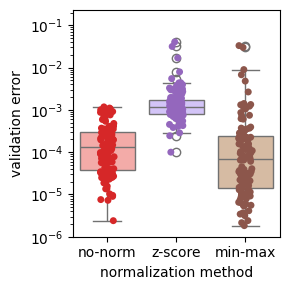

F-statistic, 32.61186904772412
p-value, 9.815539958939624e-14
Validation: 40 simulations, option_3.
 lr: 0.01, nodes: [8, 8], layers: 2, max epochs 499
 p-value: 0.0


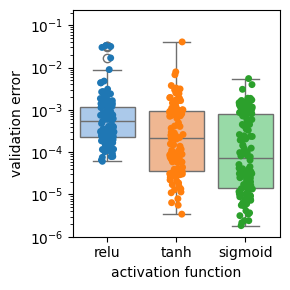

In [245]:
def boxplot(df, max_epochs):
    ymin, ymax = 10**-6, 2.3*10**-1

    df_plot = df[(df["epoch"] == max_epochs)]
    df_plot.loc[:,'log_validation'] = np.log10(df_plot['validation'])
        # 1) ALL
    # Two-way ANOVA
    all_normalization_methods= ['no-norm', 'z-score', 'min-max']
    all_activation_functions = ['relu', 'tanh', 'sigmoid' ]
    group_data = [df_plot[(df_plot['normalization_method']==norm_method)&(df_plot['activation_function']==activ_func)]['log_validation'] for norm_method in all_normalization_methods for activ_func in all_activation_functions]
    shapiro_and_levenes_test(group_data, alpha=0.05)

    statistic_bool = True
    if statistic_bool:
        model = ols('log_validation ~ C(normalization_method) + C(activation_function) + C(normalization_method):C(activation_function)', data=df_plot).fit()
        anova_table = sm.stats.anova_lm(model, type=2)

    plt.figure(figsize=(3, 3))

    order=['relu', 'tanh', 'sigmoid']
    ax = sns.boxplot(data=df_plot, x="normalization_method", y="validation", hue_order=order,hue="activation_function", palette='pastel', log_scale=True)
    sns.stripplot(data=df_plot, x="normalization_method", y="validation", hue_order=order,hue="activation_function", dodge=True, palette='tab10')
    plt.yscale('log')
    if statistic_bool:
        # plt.text(0.5, 0.1, f'Factor1 p-value: {anova_table["PR(>F)"].iloc[0]:.4f}', ha='center', transform=plt.gca().transAxes) #gca (get current axes), transAxes: zorgt ervoor dat coordinaat linksonder (0,0) en rechtsboven (1,1)
        # plt.text(0.5, 0.05, f'Factor2 p-value: {anova_table["PR(>F)"].iloc[1]:.4f}', ha='center', transform=plt.gca().transAxes)
        # plt.text(0.5, 0.0, f'Interaction p-value: {anova_table["PR(>F)"].iloc[2]:.4f}', ha='center', transform=plt.gca().transAxes)

        print(f'Factor1 p-value: {anova_table["PR(>F)"].iloc[0]:.4f}') #gca (get current axes), transAxes: zorgt ervoor dat coordinaat linksonder (0,0) en rechtsboven (1,1)
        print(f'Factor2 p-value: {anova_table["PR(>F)"].iloc[1]:.4f}')
        print(f'Interaction p-value: {anova_table["PR(>F)"].iloc[2]:.4f}')


    # handles, labels = ax.get_legend_handles_labels()
    # plt.legend(handles[3:6], labels[3:6], loc='upper right')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:3], labels[0:3], loc='upper left', ncols=2, labelspacing=0.2,columnspacing=0.5, frameon=False, bbox_to_anchor=[0.02, 1.04])

    # plt.title(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n")
    print(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n")
    # plt.ylim([4*10**-7, 10**-2])
    # plt.ylim([10**-6, 10**-1])
    plt.ylim(ymin, ymax)

    ax.set(xlabel='normalization method', ylabel='validation error')

    plt.tight_layout()
    mpl.rc("savefig", dpi=300)
    plt.savefig(r"C:\Users\jimmy\OneDrive\Documents\Universiteit\KULeuven\Masterproef\Thesis_Fig\Results\val_boxplot_all_88_0.01_499_40_100.png")

    plt.show()

    # 2) Together Normalization Method
    # Anova-test
    p_value = None # such that don't take other p-value from previous
    if statistic_bool:
        all_normalization_methods = ['no-norm', 'z-score', 'min-max']
        group_data = [df_plot[(df_plot["normalization_method"] == norm_method)]["log_validation"] for norm_method in all_normalization_methods]
        f_statistic, p_value = f_oneway(*group_data)
        print(f"p-value, {p_value}")
        p_value = round(p_value, 4)

    plt.figure(figsize=(3, 3))

    palette1 = sns.color_palette('pastel')[3:6]
    palette2 = sns.color_palette('tab10')[3:6]

    norm_order = ['no-norm', 'z-score', 'min-max']
    ax = sns.boxplot(data=df_plot, x="normalization_method", y="validation", hue_order = norm_order, hue="normalization_method", palette=palette1, log_scale=True)
    sns.stripplot(data=df_plot, x="normalization_method", y="validation", hue_order=norm_order, hue="normalization_method", palette=palette2)

    plt.yscale('log')
    # plt.ylim([4*10**-7, 10**-2])
    # plt.ylim([10**-6, 10**-1])
    plt.ylim(ymin, ymax)

    # plt.legend(handles[0:3], labels[0:3], loc='upper left', ncols=2, labelspacing=0.2,columnspacing=0.5, frameon=False)
    ax.set(xlabel='normalization method', ylabel='validation error')

    # plt.title(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n p-value: {p_value}")
    print(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n p-value: {p_value}")
    
    plt.tight_layout()
    mpl.rc("savefig", dpi=300)
    plt.savefig(r"C:\Users\jimmy\OneDrive\Documents\Universiteit\KULeuven\Masterproef\Thesis_Fig\Results\val_boxplot_norm_88_0.01_499_40_100.png")


    plt.show()

    # 3) Together Activation Function
    p_value = None
    if statistic_bool:
        all_activation_functions=['relu', 'tanh', 'sigmoid']
        group_data = [df_plot[(df_plot["activation_function"] == activ_function)]["log_validation"] for activ_function in all_activation_functions]
        f_statistic, p_value = f_oneway(*group_data)
        print(f"F-statistic, {f_statistic}")
        print(f"p-value, {p_value}")
        p_value = round(p_value, 4)

    plt.figure(figsize=(3, 3))

    ax = sns.boxplot(data=df_plot, x="activation_function", y="validation", order=order, hue_order=order,hue="activation_function", palette='pastel', log_scale=True)
    sns.stripplot(data=df_plot, x="activation_function", y="validation", order=order, hue_order=order,hue="activation_function", palette='tab10')
    plt.yscale('log')
    # plt.ylim([4*10**-7, 10**-2])
    plt.ylim([10**-6, 10**-1])
    plt.ylim(ymin, ymax)


    ax.set(xlabel='activation function', ylabel='validation error')
    print(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n p-value: {p_value}")
    # plt.title(f"Validation: {average} simulations, {option}.\n lr: {learning_rate}, nodes: {nodes}, layers: {layers}, max epochs {max_epochs}\n p-value: {p_value}")
    
    plt.tight_layout()
    mpl.rc("savefig", dpi=300)
    plt.savefig(r"C:\Users\jimmy\OneDrive\Documents\Universiteit\KULeuven\Masterproef\Thesis_Fig\Results\val_boxplot_act_88_0.01_499_40_100.png")

    plt.show()

boxplot(df_selection, max_epochs)

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import f_oneway

def plot_together_3by3_all_val_new(end_validation_data, std_dev_validation_functions, end_training_data, std_dev_training, normalization_method, activation_function, max_epochs):
    fig = plt.figure(constrained_layout=True, figsize=(15, 10))
    gs = fig.add_gridspec(4, 4)

    # 3x3 grid of subplots
    axs_3x3 = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]

    min_loss_tot = np.infty
    max_loss_tot = -np.infty

    for i in range(3):
        for j in range(3):
            min_loss_tot = min(min(end_training_data[j][i]), min_loss_tot)
            max_loss_tot = max(max(end_validation_data[j][i]), max_loss_tot)

    activation_function = ['ReLU', 'Tanh', 'Sigmoid']
    epochs = np.arange(0, max_epochs+1)
    for n, i in enumerate(normalization_method): # over normalization
        for m, j in enumerate(activation_function): # over activation
            axs_3x3[n][m].plot(epochs, end_validation_data[m][n], color='C1', label='validation')
            axs_3x3[n][m].fill_between(epochs, end_validation_data[m][n]-std_dev_validation_functions[m][n], end_validation_data[m][n]+std_dev_validation_functions[m][n], color='C1', alpha=0.2)
            axs_3x3[n][m].plot(epochs, end_training_data[m][n], color='blue', label='training')
            axs_3x3[n][m].fill_between(epochs, end_training_data[m][n]-std_dev_training[m][n], end_training_data[m][n]+std_dev_training[m][n], color='blue', alpha=0.3)
            axs_3x3[n][m].set_title(str(i) + ", " + str(j))
            axs_3x3[n][m].set_yscale('log')
            axs_3x3[n][m].set_ylim([min_loss_tot, max_loss_tot])
            axs_3x3[n][m].set_xticks([0, 500])
            axs_3x3[n][m].set_yticks([0.1, 0.01, 0.001, 0.0001])
            axs_3x3[n][m].set_xlabel("Epoch")
            axs_3x3[n][m].set_ylabel("Validation Loss")
    axs_3x3[0][0].legend(frameon=False, bbox_to_anchor=[0.04, 1.15], loc='upper left', labelspacing=0.3)

    plt.tight_layout()
    return fig, gs

def boxplot_new(df, max_epochs):
    df_plot = df[(df["epoch"] == max_epochs)]
    df_plot.loc[:, 'log_validation'] = np.log10(df_plot['validation'])

    order = ['relu', 'tanh', 'sigmoid']
    
    # Create a new figure and gridspec layout
    fig, gs = plot_together_3by3_all_val_new(end_val_data, std_dev_val, end_training_data, std_dev_training, normalization_method, activation_function, max_epochs)

    # Top right subplot
    ax_top_right = fig.add_subplot(gs[0:2, 3])
    sns.boxplot(data=df_plot, x="normalization_method", y="validation", hue_order=order, hue="activation_function", palette='pastel', ax=ax_top_right)
    sns.stripplot(data=df_plot, x="normalization_method", y="validation", hue_order=order, hue="activation_function", palette='tab10', ax=ax_top_right)
    ax_top_right.set_yscale('log')
    ax_top_right.legend().set_visible(False)

    # Bottom left subplot
    ax_bottom_left = fig.add_subplot(gs[2:, 0:2])
    palette1 = sns.color_palette('pastel')[3:6]
    palette2 = sns.color_palette('tab10')[3:6]
    norm_order = ['no-norm', 'z-score', 'min-max']
    sns.boxplot(data=df_plot, x="normalization_method", y="validation", hue_order=norm_order, hue="normalization_method", palette=palette1, ax=ax_bottom_left)
    sns.stripplot(data=df_plot, x="normalization_method", y="validation", hue_order=norm_order, hue="normalization_method", palette=palette2, ax=ax_bottom_left)
    ax_bottom_left.set_yscale('log')

    # Bottom right subplot
    ax_bottom_right = fig.add_subplot(gs[2:, 2:])
    sns.boxplot(data=df_plot, x="activation_function", y="validation", order=order, hue_order=order, hue="activation_function", palette='pastel', ax=ax_bottom_right)
    sns.stripplot(data=df_plot, x="activation_function", y="validation", order=order, hue_order=order, hue="activation_function", palette='tab10', ax=ax_bottom_right)
    ax_bottom_right.set_yscale('log')

    plt.show()

# Example usage:
# Assuming you have your data ready in end_validation_data, std_dev_validation_functions, end_training_data, std_dev_training, normalization_method, and activation_function.
# Also assuming your DataFrame `df` is ready for the `boxplot` function.

# boxplot(df, max_epochs)


C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\2878083311.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:, 'log_validation'] = np.log10(df_plot['validation'])
C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\2878083311.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


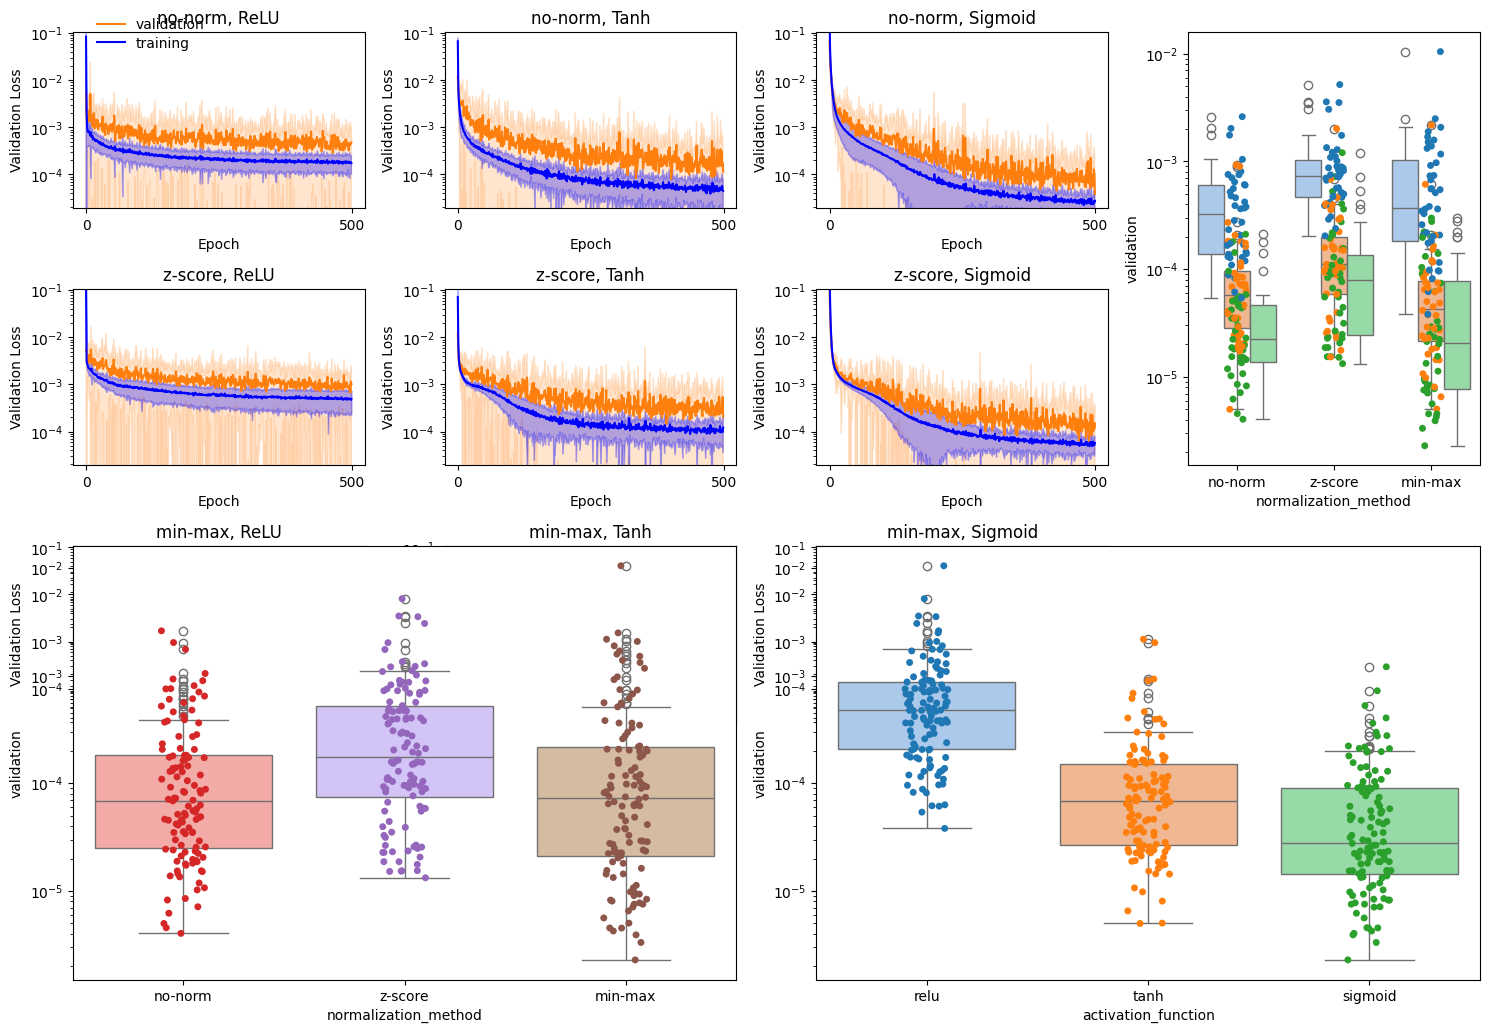

In [78]:
boxplot_new(df_selection, max_epochs, )


C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\3376680025.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:,'log_validation'] = np.log10(df_plot['validation'])
C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\3376680025.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.loc[:,'log_validation'] = np.log10(df_plot['validation'])
C:\Users\jimmy\AppData\Local\Temp\ipykernel_4508\3376680025.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

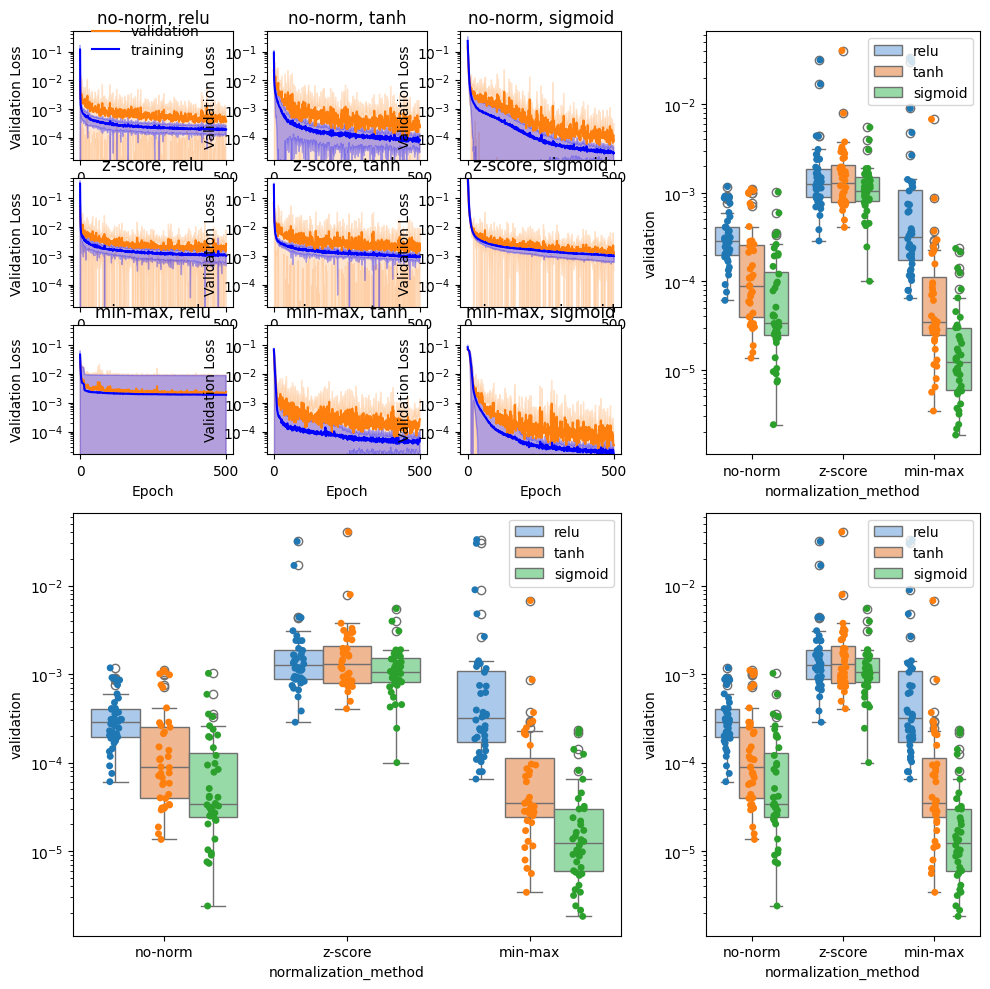

In [319]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Define the plotting functions
def plot_together_3by3_all_val_new2(axs, end_validation_data, std_dev_validation_functions, end_training_data, std_dev_training, normalization_method, activation_function, max_epochs):
    min_loss_tot = np.infty
    max_loss_tot = -np.infty

    for i in range(3):
        for j in range(3):
            min_loss_tot = min(min(end_training_data[j][i]), min_loss_tot)
            max_loss_tot = max(max(end_validation_data[j][i]), max_loss_tot)

    epochs = np.arange(0, max_epochs+1)
    for n, i in enumerate(normalization_method): # over normalization
        for m, j in enumerate(activation_function): # over activation
            axs[n, m].plot(epochs, end_validation_data[m][n], color='C1', label='validation')
            axs[n, m].fill_between(epochs, end_validation_data[m][n]-std_dev_validation_functions[m][n], end_validation_data[m][n]+std_dev_validation_functions[m][n], color='C1', alpha=0.2)
            axs[n, m].plot(epochs, end_training_data[m][n], color='blue', label='training')
            axs[n, m].fill_between(epochs, end_training_data[m][n]-std_dev_training[m][n], end_training_data[m][n]+std_dev_training[m][n], color='blue', alpha=0.3)
            axs[n, m].set_title(str(i) + ", " + str(j))
            axs[n, m].set_yscale('log')
            axs[n, m].set_ylim([min_loss_tot, max_loss_tot])
            axs[n,m].set_xticks([0, 500])
            axs[n,m].set_yticks([0.1, 0.01, 0.001, 0.0001])
            axs[n, m].set_xlabel("Epoch")
            axs[n,m].set_ylabel("Validation Loss")

    axs[0,0].legend(frameon=False, bbox_to_anchor=[0.04, 1.15], loc='upper left', labelspacing=0.3)

def boxplot_new2(ax, df, max_epochs):
    df_plot = df[(df["epoch"] == max_epochs)]
    df_plot.loc[:,'log_validation'] = np.log10(df_plot['validation'])

    order=['relu', 'tanh', 'sigmoid']
    sns.boxplot(data=df_plot, x="normalization_method", y="validation", hue_order=order, hue="activation_function", palette='pastel', ax=ax)
    sns.stripplot(data=df_plot, x="normalization_method", y="validation", hue_order=order, hue="activation_function", dodge=True, palette='tab10', ax=ax)
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], loc='upper right')

# Create the figure and the grid layout
fig = plt.figure(figsize=(10, 10))

# Create a 2x2 grid
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Create a 3x3 grid inside the top-left cell of the 2x2 grid
gs0 = gs[0, 0].subgridspec(3, 3)

# Create the axes for the 3x3 grid
axs0 = np.array([[fig.add_subplot(gs0[i, j]) for j in range(3)] for i in range(3)])

# Generate example data
# max_epochs = 100
# normalization_method = ['no-norm', 'z-score', 'min-max']
# activation_function = ['ReLU', 'Tanh', 'Sigmoid']
# end_validation_data = np.random.rand(3, 3, max_epochs+1)
# std_dev_validation_functions = np.random.rand(3, 3, max_epochs+1) * 0.1
# end_training_data = np.random.rand(3, 3, max_epochs+1)
# std_dev_training = np.random.rand(3, 3, max_epochs+1) * 0.1

# Plot the 3x3 grid
plot_together_3by3_all_val_new2(axs0, end_val_data, std_dev_val, end_training_data, std_dev_training, normalization_method, activation_function, max_epochs)

# Example DataFrame

# Create the other three subplots
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Plot the seaborn boxplots
boxplot_new2(ax1, df_selection, max_epochs)
boxplot_new2(ax2, df_selection, max_epochs)
boxplot_new2(ax3, df_selection, max_epochs)

plt.tight_layout()
plt.show()


In [322]:
import FitzHugh_Nagumo_ps
importlib.reload(FitzHugh_Nagumo_ps)
from FitzHugh_Nagumo_ps import nullcline_and_boundary, nullcline_vdot, nullcline_wdot,calculate_mean_squared_error, limit_cycle
from create_NN_FHN import normalization_with_mean_std, reverse_normalization
from keras.models import load_model, Model
TAU = 100

def normalize_axis_values(axis_value, all_mean_std, option):
    """We have values of the x/or/y axis of the phase space and returns the normalized versions.
    
    This is needed because the neural network model only takes in normalized inputs.
    """
    if option == 'option_1': # nullcine is udot/wdot = 0
        # axis value in this case is the x-axis (v-axis)
        mean_std = all_mean_std["v_t_data_norm"]
        normalized_axis_values = normalization_with_mean_std(axis_value, mean_std)

        # nullcline of option 1, udot/wdot = 0, so we have to fill in zeros (but has to be normalized first for the model)
        mean_std = all_mean_std["u_dot_t_data_norm"]
        normalized_dot = normalization_with_mean_std(np.zeros(len(axis_value)), mean_std)

        # The mean std that will be used later for reversing the normalization
        reverse_norm_mean_std = all_mean_std["u_t_data_norm"]

    if option == 'option_2':
        # axis value in this case is the y-axis (w-axis / u-axis)
        mean_std = all_mean_std["u_t_data_norm"]
        normalized_axis_values = normalization_with_mean_std(axis_value, mean_std)

        # nullcine of option 2, udot/wdot = 0, so we have to fill in zeros (but has to be normalized first for the model)
        mean_std = all_mean_std["u_dot_t_data_norm"]
        normalized_dot = normalization_with_mean_std(np.zeros(len(axis_value)), mean_std)

        # The mean std that will be used later for reversing the normalization
        reverse_norm_mean_std = all_mean_std["v_t_data_norm"]

    if option == 'option_3':
        # axis value in this case is the x-axis (v-axis)
        mean_std = all_mean_std["v_t_data_norm"]
        normalized_axis_values = normalization_with_mean_std(axis_value, mean_std)

        # nullcine of option 3, vdot = 0, so we have to fill in zeros (but has to be normalized first for the model)
        mean_std = all_mean_std["v_dot_t_data_norm"]
        normalized_dot = normalization_with_mean_std(np.zeros(len(axis_value)), mean_std)

        # The mean std that will be used later for reversing the normalization
        reverse_norm_mean_std = all_mean_std["u_t_data_norm"]

    if option == 'option_4':
        # just give some result so program is generalizable, do not trust said values
        normalized_axis_values = axis_value
        normalized_dot = np.zeros(len(axis_value))

        reverse_norm_mean_std = [0,1]

    input_prediction = np.column_stack((normalized_axis_values, normalized_dot))

    return input_prediction, reverse_norm_mean_std


def retrieve_model_from_name(unique_modelname) -> Model:
    """Give the modelname and returns the keras.Model
    
    Parameters:
    - unique_modelname (str): Modelname

    Returns:
    - None
    """
    # absolute_path = os.path.dirname(__file__)
    absolute_path = os.path.abspath('')

    relative_path = "saved_NN_models"
    folder_path = os.path.join(absolute_path, relative_path)
    full_path = os.path.join(folder_path, unique_modelname + '.h5')
    if not os.path.exists(full_path):
        assert False, f"The model with name {unique_modelname} cannot be found in path {full_path}"
    loaded_model = load_model(full_path)
    return loaded_model

def plot_lc_from_modelname(modelname, title_extra='', plot_bool=True, df=None):
    """
    Plots the nullcline on the phase space.

    Parameters:
    - modelname (str): Name of the model.
    - title_extra (str): Additional information to add to the title, ex. 'low val, high MSE'.
    - plot_bool (bool): Boolean indicating whether to plot the nullcline or not.
    - df (DataFrame): DataFrame containing model information.

    Returns:
    - tuple: Tuple containing axis values for nullcline, prediction output, and DataFrame.

    Notes:
    - If df is not provided, the function reads the data from a default CSV file.
    """
    
    if df is None:
        start_time = time.time()
        absolute_path = os.path.abspath('')
        # absolute_path = os.path.dirname(__file__)
        relative_path = f"FHN_NN_loss_and_model_{TAU}.csv"
        csv_name = os.path.join(absolute_path, relative_path)
        df = pd.read_csv(csv_name, converters={"nodes": literal_eval, "mean_std": literal_eval}, engine='c') # literal eval returns [2,2] as list not as str
        
        end_time = time.time()
        print('took seconds:', end_time - start_time)

    option = df[(df['modelname'] == modelname)]['option'].iloc[0]
    mean_std = df[(df['modelname'] == modelname)]['mean_std'].iloc[0]
    learning_rate = df[(df['modelname'] == modelname)]['learning_rate'].iloc[0]
    nodes = df[(df['modelname'] == modelname)]['nodes'].iloc[0]
    layers = df[(df['modelname'] == modelname)]['layers'].iloc[0]
    max_epochs = df[(df['modelname'] == modelname)]['epoch'].iloc[-1]
    normalization_method = df[(df['modelname'] == modelname)]['normalization_method'].iloc[0]
    activation_function = df[(df['modelname'] == modelname)]['activation_function'].iloc[0]

    print(option, mean_std)
    model = retrieve_model_from_name(modelname)

    # load data of nullclines in phasespace
    amount_of_points = 500
    axis_values_for_nullcline, exact_nullcline_values = nullcline_and_boundary(option, amount_of_points)

    # Predict normalized data 
    input_prediction, reverse_norm_mean_std = normalize_axis_values(axis_values_for_nullcline, mean_std, option)
    prediction_output_normalized = model.predict(input_prediction)
    # Reverse normalize to 'normal' data
    prediction_output_column = reverse_normalization(prediction_output_normalized, reverse_norm_mean_std)
    prediction_output = prediction_output_column.reshape(-1)
    
    plt.subplots(figsize=(3, 3))

    if plot_bool:
        # plot normal LC
        x_lc, y_lc = limit_cycle(tau=100)
        # plt.plot(x_lc, y_lc, 'r-', label=f'Trajectory')
        plt.scatter(x_lc, y_lc, color='red', label=f'Trajectory', alpha=0.01, s=2)
        plt.plot([100], [200], color='red', label=f'Limit cycle', zorder=10)


        # Plot Nullcines
        # vdot
        v = np.linspace(-2.5, 2.5, 1000)
        plt.plot(v, nullcline_vdot(v), '--', color = "lime", label = r"$\dot{v}=0$ nullcline") #$w=v - (1/3)*v**3 + R * I$"+r" ,
        # wdot
        v = np.linspace(-2.5, 2.5, 1000)
        plt.plot(v, nullcline_wdot(v), '--', color = "cyan", label = r"$\dot{w}=0$ nullcline") #$w=(v + A) / B$"+r" ,

        if option == 'option_1' or option == 'option_3':
            plt.plot(axis_values_for_nullcline, prediction_output, label = 'prediction', linewidth=2)
        if option == 'option_2' or option == 'option_4':
            plt.plot(prediction_output, axis_values_for_nullcline, label = 'prediction', linewidth=2)
        plt.xlabel(r'$v$ (voltage)')
        plt.ylabel(r'$w$ (recovery variable)')
        # plt.title(f"Phase Space: Limit Cycle and Cubic Nullcline with Prediction\n{option}, lr{learning_rate}, {nodes}, epoch {max_epochs}\n {normalization_method}, {activation_function}\n{title_extra}")
        print(f"Phase Space: Limit Cycle and Cubic Nullcline with Prediction\n{option}, lr{learning_rate}, {nodes}, epoch {max_epochs}\n {normalization_method}, {activation_function}\n{title_extra}")

        xmin = -2.2
        xmax = 2.2
        ymin = -0.2
        ymax = 2.2
        plt.ylim(ymin, ymax)
        plt.xlim(xmin, xmax)

        plt.grid(True)
        plt.tight_layout()

        mpl.rc("savefig", dpi=300)
        plt.savefig(r"C:\Users\jimmy\OneDrive\Documents\Universiteit\KULeuven\Masterproef\Thesis_Fig\Results\Predictions\Horizontal_Predict_100.png")

        

        plt.show()
    return (axis_values_for_nullcline, prediction_output, df)

In [311]:
print(TAU)

100


option_3 {'u_t_data_norm': [0.09537434012498179, 1.906636071351641], 'v_t_data_norm': [-1.8983829676598698, 3.7949946152478296], 'u_dot_t_data_norm': [-0.3155438466430583, 0.6029539440244842], 'v_dot_t_data_norm': [-1.4615857778767594, 2.888070808283267]}
{'option_1': [-0.46058815967056566, 0.6640071339417826], 'option_2': [0.2777716672863017, 1.7063393716936397], 'option_3': [-1.9921366768785793, 2.0002253002879904], 'option_4': [0.33333333333333326, 1.6666666666666667]}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Phase Space: Limit Cycle and Cubic Nullcline with Prediction
option_3, lr0.01, [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], epoch 499
 min-max, relu



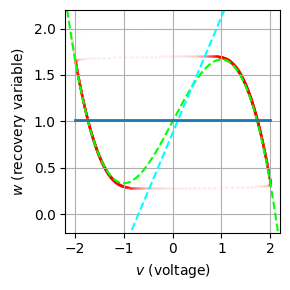

(array([-1.99213668e+00, -1.98413595e+00, -1.97613523e+00, -1.96813450e+00,
        -1.96013378e+00, -1.95213305e+00, -1.94413232e+00, -1.93613160e+00,
        -1.92813087e+00, -1.92013015e+00, -1.91212942e+00, -1.90412870e+00,
        -1.89612797e+00, -1.88812725e+00, -1.88012652e+00, -1.87212580e+00,
        -1.86412507e+00, -1.85612434e+00, -1.84812362e+00, -1.84012289e+00,
        -1.83212217e+00, -1.82412144e+00, -1.81612072e+00, -1.80811999e+00,
        -1.80011927e+00, -1.79211854e+00, -1.78411782e+00, -1.77611709e+00,
        -1.76811637e+00, -1.76011564e+00, -1.75211491e+00, -1.74411419e+00,
        -1.73611346e+00, -1.72811274e+00, -1.72011201e+00, -1.71211129e+00,
        -1.70411056e+00, -1.69610984e+00, -1.68810911e+00, -1.68010839e+00,
        -1.67210766e+00, -1.66410694e+00, -1.65610621e+00, -1.64810548e+00,
        -1.64010476e+00, -1.63210403e+00, -1.62410331e+00, -1.61610258e+00,
        -1.60810186e+00, -1.60010113e+00, -1.59210041e+00, -1.58409968e+00,
        -1.5

In [323]:
plot_lc_from_modelname('76da590b9b4c4c41a0fb3a8bc58fad38', df=df_overall_tau7_5) # example 1: 16layers 8 nodes minmax, relu   (tau7.5)


In [305]:
from Nullcine_MSE_plot import open_csv_and_return_all
from plot_NN_ps import average_lc_from_modelnames

def plot_best_avg_param(option, learning_rate, max_epochs, nodes, layers, normalization_method, activation_function, df=None):
    """
    Plots the phase space with averaged predictions showing deviation from ONLY the 5 best performing models.

    Parameters:
    - option (str): Option used in the analysis.
    - learning_rate (float): Learning rate used.
    - max_epochs (int): Maximum number of epochs.
    - nodes (int): Number of nodes.
    - layers (int): Number of layers.
    - normalization_method (str): Method used for normalization.
    - activation_function (str): Activation function used.

    Returns:
    - None

    Notes:
    - Averages predictions with deviation from the best and worst performing models using 'search_5_best_5_worst_modelnames'.
    """

    best_worst_modelnames_dict, _ = search_5_best_5_worst_modelnames(option, learning_rate, max_epochs, nodes, layers, normalization_method, activation_function)
    best_modelnames = best_worst_modelnames_dict['best models']
    performance_modelname = 'best' # for in the title, this function plots the best modelnames
    axis_value, mean_prediction, _ = average_lc_from_modelnames(best_modelnames, performance_modelname, df,option, nodes, learning_rate, max_epochs, normalization_method, activation_function)
    return axis_value, mean_prediction

def search_5_best_5_worst_modelnames(option, learning_rate, max_epochs, nodes, layers, normalization_method, activation_function):
    """
    Retrieves the names of the 5 best and 5 worst models based on validation performance.

    Parameters:
    - option (str): Option used in the analysis.
    - learning_rate (float): Learning rate used.
    - max_epochs (int): Maximum number of epochs.
    - nodes (int): Number of nodes.
    - layers (int): Number of layers.
    - normalization_method (str): Method used for normalization.
    - activation_function (str): Activation function used.

    Returns:
    - dict: A dictionary containing the names of the 5 best and 5 worst models under 'best models' and 'worst models' keys respectively.
    """

    df = open_csv_and_return_all(option, learning_rate, max_epochs, nodes, layers, amount=40, normalization_methods=[normalization_method], activation_functions=[activation_function])

    df_selection = df[(df['normalization_method'] == normalization_method) & (df['activation_function'] == activation_function)].copy()

    df_sorted = df_selection.sort_values(by=['validation'], ascending=True)

    cut_off = 5
    best_models = df_sorted.iloc[:5]['modelname'].tolist()
    print("Mse of 5 best models", df_sorted.iloc[:5]['MSE'].tolist())
    worst_models = df_sorted.tail(cut_off)['modelname'].tolist()

    return {'best models': best_models, 'worst models': worst_models}, df_sorted



In [306]:
plot_best_avg_param(option='option_3', learning_rate=0.01, max_epochs=499, nodes=[8,8], layers=2, normalization_method='min-max', activation_function='relu',df=df_overall_tau7_5)


Mse of 5 best models [0.0021210085408879, 0.0037380434401407, 0.001332944044096, 0.0035248342342453, 0.0006027216319549]
0c42ad7190bf46e78c11f5ca5169bffb <class 'str'>
<class 'pandas.core.frame.DataFrame'>          run normalization_method activation_function  learning_rate   nodes  \
0          0              no-norm                relu           0.01  [8, 8]   
1          0              no-norm                relu           0.01  [8, 8]   
2          0              no-norm                relu           0.01  [8, 8]   
3          0              no-norm                relu           0.01  [8, 8]   
4          0              no-norm                relu           0.01  [8, 8]   
...      ...                  ...                 ...            ...     ...   
1495495   39              min-max             sigmoid           0.01  [8, 8]   
1495496   39              min-max             sigmoid           0.01  [8, 8]   
1495497   39              min-max             sigmoid           0.01  [8, 

IndexError: single positional indexer is out-of-bounds